## Предсказание положения космических объектов

https://www.kaggle.com/c/sputnik

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('sputnik/train.csv', sep =',')
df.head(2)

,id,epoch,sat_id,x,y,z,x_sim,y_sim,z_sim,type
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-8843.131454,13138.221690,-20741.615306,train
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-10555.500066,1649.289367,-24473.089556,train


In [3]:
df.epoch = pd.to_datetime(df.epoch, format='%Y-%m-%d %H:%M:%S')
df.index  = df.epoch
df = df.drop('epoch', axis = 1)
df.head(2)

,id,sat_id,x,y,z,x_sim,y_sim,z_sim,type
epoch,,,,,,,,,
2014-01-01 00:00:00,0,0,-8855.823863,13117.780146,-20728.353233,-8843.131454,13138.221690,-20741.615306,train
2014-01-01 00:46:43,1,0,-10567.672384,1619.746066,-24451.813271,-10555.500066,1649.289367,-24473.089556,train


In [4]:
train = df[df.type == "train"]
test =  df[df.type == "test"]

In [5]:
train['error']  = np.linalg.norm(train[['x', 'y', 'z']].values - \
                                 train[['x_sim', 'y_sim', 'z_sim']].values, axis=1)

In [6]:
test_groups = {i: test[test.sat_id == i] for i in test.sat_id.unique()}
train_groups = {i: train[train.sat_id == i] for i in train.sat_id.unique()}

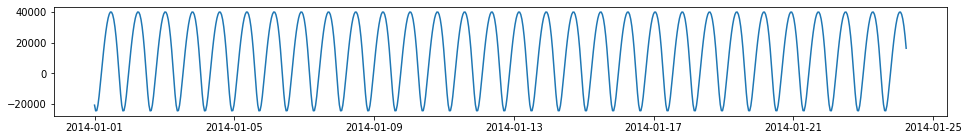

In [7]:
plt.figure(figsize=(16,2))
plt.plot(train_groups[0].z)
plt.show()

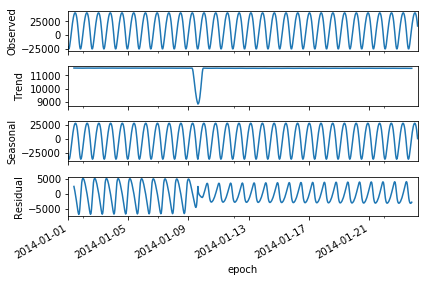

In [8]:
result = sm.tsa.seasonal_decompose(train_groups[0].z,freq= 24)
result.plot()
plt.show()

In [9]:
def predict_set(train, test_set, ndays, T):
    def learn_model(features, variable):
        model = LinearRegression()
        test_df = df[df.mark == 'test'][features]
        train_df = df[df.mark == 'train'][features + ['{}_target'.format(variable)]].dropna()
        model.fit(train_df.drop('{}_target'.format(variable), axis = 1) ,train_df['{}_target'.format(variable)])
        return model.predict(test_df)
    
    pred = pd.DataFrame()
    x_features, y_features, z_features = [], [], []
    
    train_data = train[['x', 'y', 'z']]
    test_data = test_set[['x', 'y', 'z']]
    train_data['mark'] = 'train'
    test_data['mark'] = 'test'
    df = pd.concat((train_data, test_data), axis = 0)
    df[['x_target', 'y_target', 'z_target']] = df[['x', 'y', 'z']]
    
    for period_number in range(1, ndays):
        df[["x_period_lag_{}".format(period_number), \
           "y_period_lag_{}".format(period_number), \
           "z_period_lag_{}".format(period_number)]] = \
        df[['x_target', 'y_target', 'z_target']].shift(period_number * T)
        x_features.append("x_period_lag_{}".format(period_number))
        y_features.append("y_period_lag_{}".format(period_number))
        z_features.append("z_period_lag_{}".format(period_number))

    df['x_mean_lag'] = df[x_features].mean(axis = 1)
    df['y_mean_lag'] = df[y_features].mean(axis = 1)
    df['z_mean_lag'] = df[z_features].mean(axis = 1)
    x_features.append('x_mean_lag')
    y_features.append('y_mean_lag')
    z_features.append('z_mean_lag')

    pred['x'] = learn_model(x_features, 'x')
    pred['y'] = learn_model(y_features, 'y')
    pred['z'] = learn_model(z_features, 'z')
    pred.index = test_set.index
    
    return pred

In [10]:
T = 24
max_start_ndays = 3
max_growth_ndays = 6

In [11]:
predict = pd.DataFrame()
for sat_id in tqdm(train_groups):
    ndays = min(train_groups[sat_id].shape[0] // T, max_start_ndays)
    train, test = pd.DataFrame(), pd.DataFrame()
    train[['x', 'y', 'z']] = train_groups[sat_id][['x', 'y', 'z']]
    test[['x_sim', 'y_sim', 'z_sim', 'id']] = test_groups[sat_id][['x_sim', 'y_sim', 'z_sim', 'id']]
    for test_set in [test_groups[sat_id].iloc[i * T : (i + 1) * T] for \
                   i in range(test_groups[sat_id].shape[0] // T + 1)]:
        if test_set.empty:
            continue
        train = pd.concat((train, predict_set(train, test_set, ndays, T)), axis = 0)
        if ndays < max_growth_ndays:
            ndays += 1

    test[['x', 'y', 'z']] = train[train_groups[sat_id].shape[0]:]
    test['error']  = np.linalg.norm(test[['x', 'y', 'z']].values - \
                                      test[['x_sim', 'y_sim', 'z_sim']].values, axis=1)
    predict = pd.concat((predict, test[['id', 'error']]), axis = 0)

In [12]:
predict.to_csv('prediction.csv', index = False)